In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

from utils import load_mnist
from utils.training_ae import train_autoencoder
from utils.training_dec import train_dec
from utils import plot_ae_reconstructions, plot_all_reconstructions
from utils.plotting import plot_dec_centers

from models import Autoencoder, DEC
from models.dec import target_distribution
# import umap

In [29]:
input_dim = 784
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# data, labels = load_digits(return_X_y=True)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
#
# tensor_x = torch.Tensor(data).to(device)
#
# indices = torch.arange(len(tensor_x)).to(device)
# dataset = TensorDataset(tensor_x, indices)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Autoencoder Training

In [8]:
ae = Autoencoder(input_dim, latent_dim).to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

### Uncomment the lines below for custom training

In [10]:
# img_indices = [50563, 10910, 57965]
# ae_losses, images = train_autoencoder(
#     ae,
#     train_loader,
#     ae_optimizer,
#     mse_loss,
#     epochs=10,
#     image_indices=img_indices,
# )
#
# checkpoint = {
#     "model_state": ae.state_dict(),
#     "losses": ae_losses,
#     "images": images
# }
#
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist_param.pth")
# torch.save(checkpoint, "../checkpoints/autoencoder_mnist_full.pth")

Epoch 1/10: average loss = 0.0620
Epoch 2/10: average loss = 0.0314
Epoch 3/10: average loss = 0.0237
Epoch 4/10: average loss = 0.0193
Epoch 5/10: average loss = 0.0174
Epoch 6/10: average loss = 0.0160
Epoch 7/10: average loss = 0.0148
Epoch 8/10: average loss = 0.0139
Epoch 9/10: average loss = 0.0133
Epoch 10/10: average loss = 0.0129


### Load pretrained Autoencoder

In [9]:
ae = Autoencoder()

checkpoint = torch.load("../checkpoints/autoencoder_mnist_full.pth", map_location="cpu")
ae.load_state_dict(checkpoint["model_state"])
ae_losses = checkpoint["losses"]
images = checkpoint["images"]

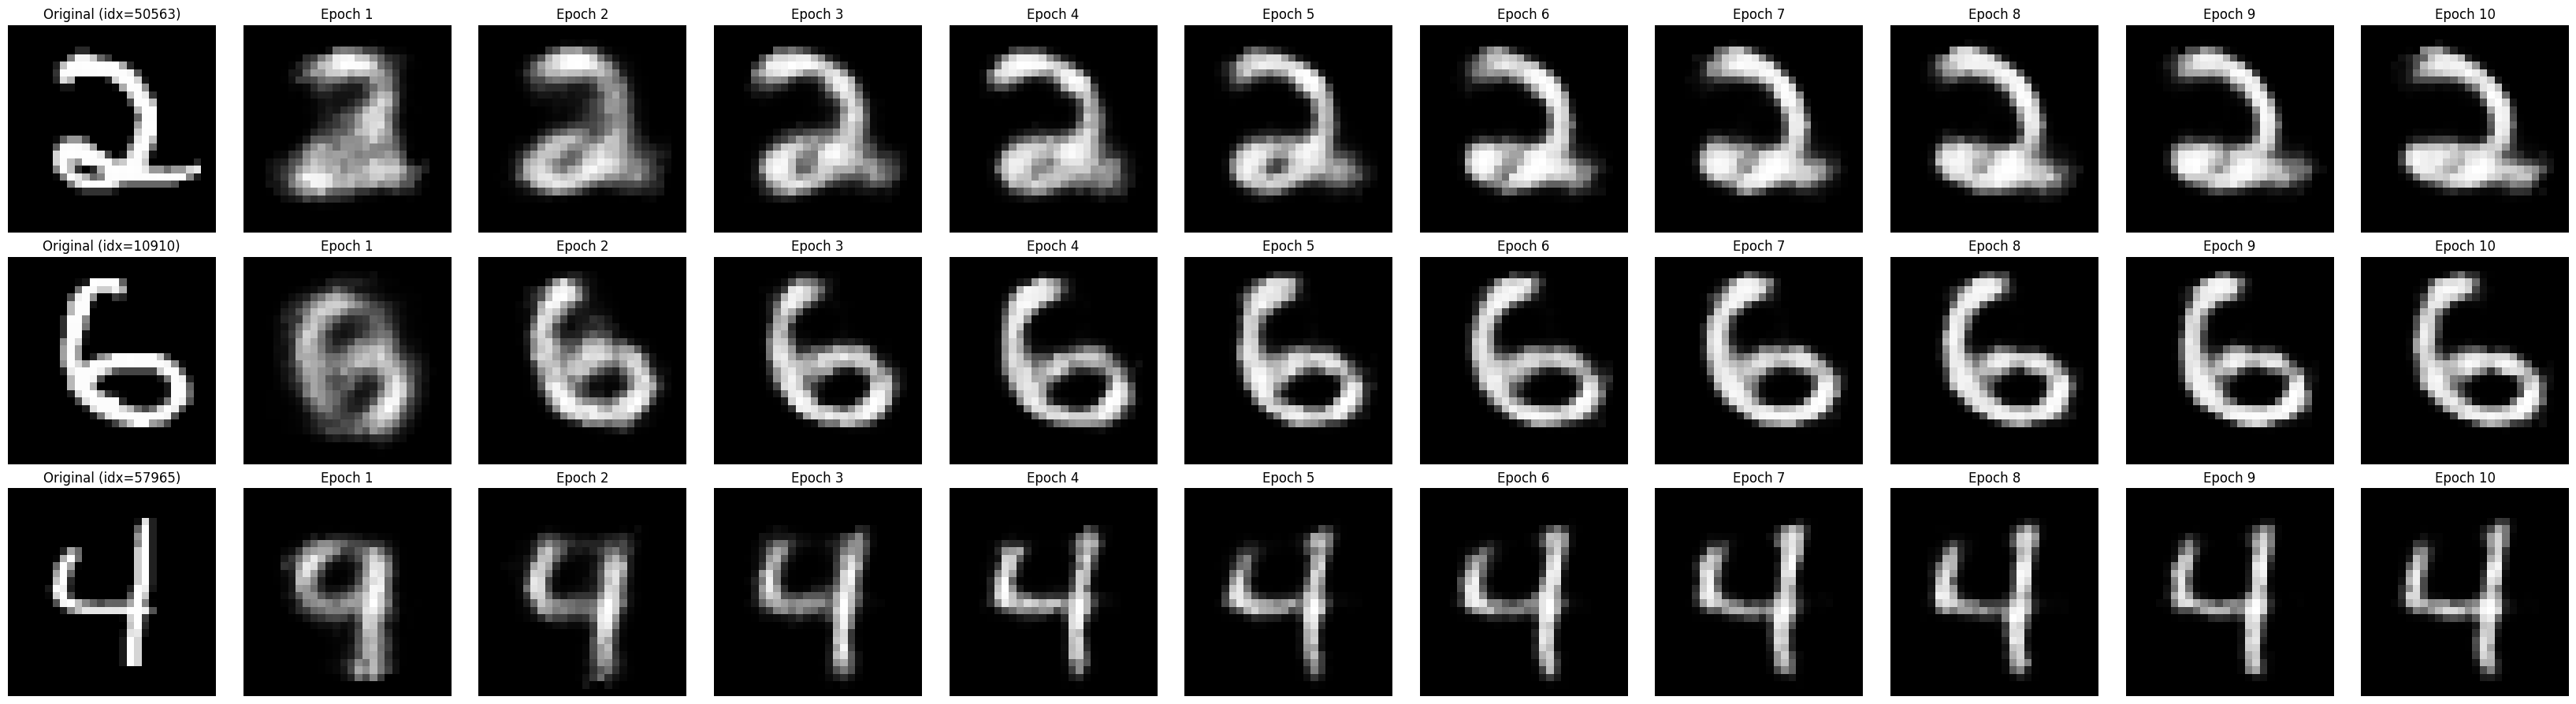

In [10]:
plot_all_reconstructions(images)

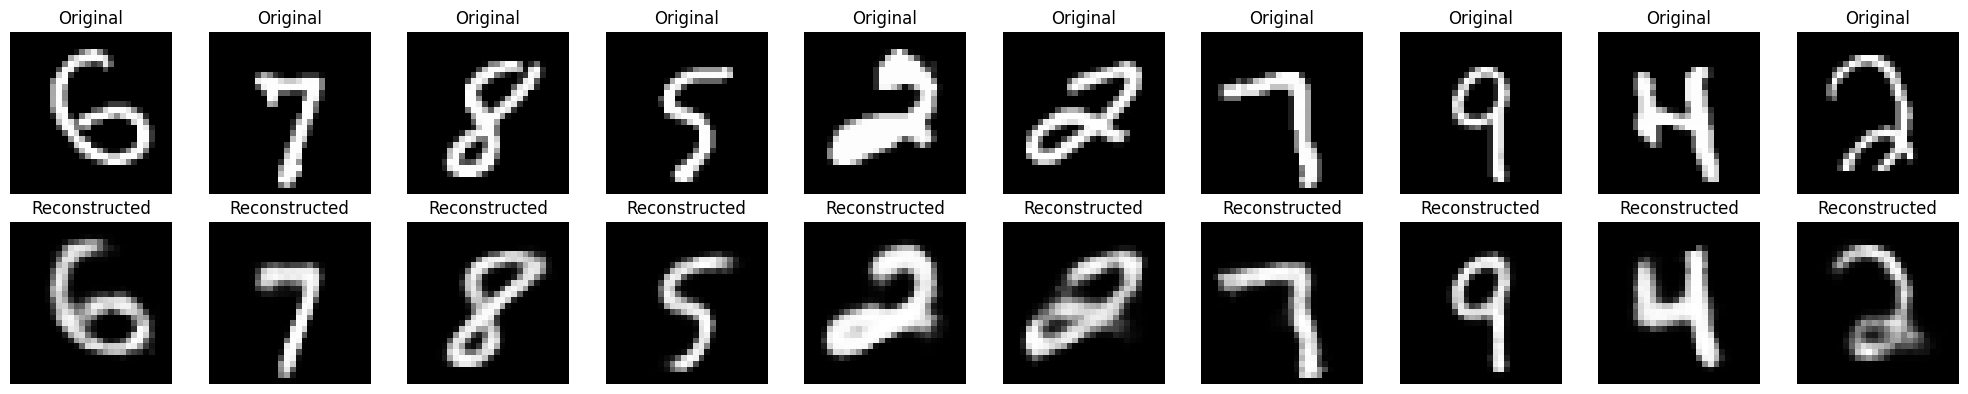

In [11]:
plot_ae_reconstructions(ae, train_dataset, device)

# DEC Training

In [12]:
dec = DEC(ae, n_clusters, latent_dim).to(device)
dec.initialize_centers(train_loader, device)

dec_optimizer = optim.SGD(dec.parameters(), lr=learning_rate, momentum=0.9)
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')

### Uncomment the lines below for custom training


In [21]:
losses = train_dec(
    dec,
    train_loader,
    dec_optimizer,
    kl_loss_fn,
    tensor_x,
    epochs=20,
    device=device,
)

Epoch 1/20: average loss = 0.1271
Epoch 2/20: average loss = 0.1237
Epoch 3/20: average loss = 0.1216
Epoch 4/20: average loss = 0.1194
Epoch 5/20: average loss = 0.1172
Epoch 6/20: average loss = 0.1152
Epoch 7/20: average loss = 0.1129
Epoch 8/20: average loss = 0.1109
Epoch 9/20: average loss = 0.1092
Epoch 10/20: average loss = 0.1075
Epoch 11/20: average loss = 0.1058
Epoch 12/20: average loss = 0.1044
Epoch 13/20: average loss = 0.1025
Epoch 14/20: average loss = 0.1010
Epoch 15/20: average loss = 0.0995
Epoch 16/20: average loss = 0.0978
Epoch 17/20: average loss = 0.0967
Epoch 18/20: average loss = 0.0954
Epoch 19/20: average loss = 0.0940
Epoch 20/20: average loss = 0.0926


In [ ]:
# torch.save(dec.state_dict(), "../checkpoints/dec_mnist_param.pth")

### Load pretrained Autoencoder

In [13]:
dec.load_state_dict(torch.load("../checkpoints/dec_mnist_param.pth"))
dec.eval()

DEC(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=10, bias=True)
  )
)

# Model evaluation

In [22]:
dec.eval()
with torch.no_grad():
    print(tensor_x.shape)
    q_final, full_z_np = dec(tensor_x)
    full_z_np = full_z_np.cpu().numpy()
    pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)

print(f"Adjusted Rand Score (ARI): {ari:.4f}")
print(f"Normalized mutual information: {nmi:.4f}")
print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

torch.Size([60000, 784])
Adjusted Rand Score (ARI): 0.6546
Normalized mutual information: 0.7419
Predicted Cluster Counts: [5661 9016 6009 6055 3816 3722 5901 7750 8047 4023]


# Plot results

In [30]:
plot_dec_centers(dec, ae)

TypeError: 'Autoencoder' object is not iterable

[35068, 12305, 25372, 52800, 18021, 59634, 42315, 9070, 42870, 12240]
Cluster assignments: [[0.00772592 0.0119528  0.8959632  0.01170208 0.00829553 0.02460474
  0.01150074 0.01127101 0.00863101 0.00835296]]
Latent space: [[ 3.9643598   2.0729582  -0.82942903 -1.6700273   0.17896125 -0.59453195
  -2.9292903   0.6757485   0.17544867 -3.3533242 ]]


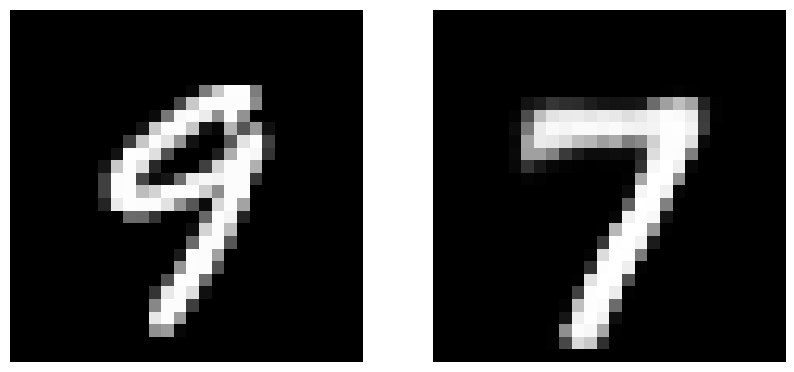

In [19]:
idx = torch.randint(len(train_dataset), size=(1,)).item()
img, label = train_dataset[idx]
img = img.squeeze()

indices = []

while True:
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[idx]
    if label == 9:
        indices.append(idx)

    if len(indices) == 10:
        break

print(indices)

# Plot original Image

q, z = dec(img.reshape(1, 784))

print(f'Cluster assignments: {q.detach().numpy()}')
print(f'Latent space: {z.detach().numpy()}')

img_recon = ae.decoder(z).detach().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.squeeze(), cmap="gray")
ax[0].axis('off')

ax[1].imshow(img_recon.reshape(28, 28), cmap="gray")
ax[1].axis('off')

plt.show()


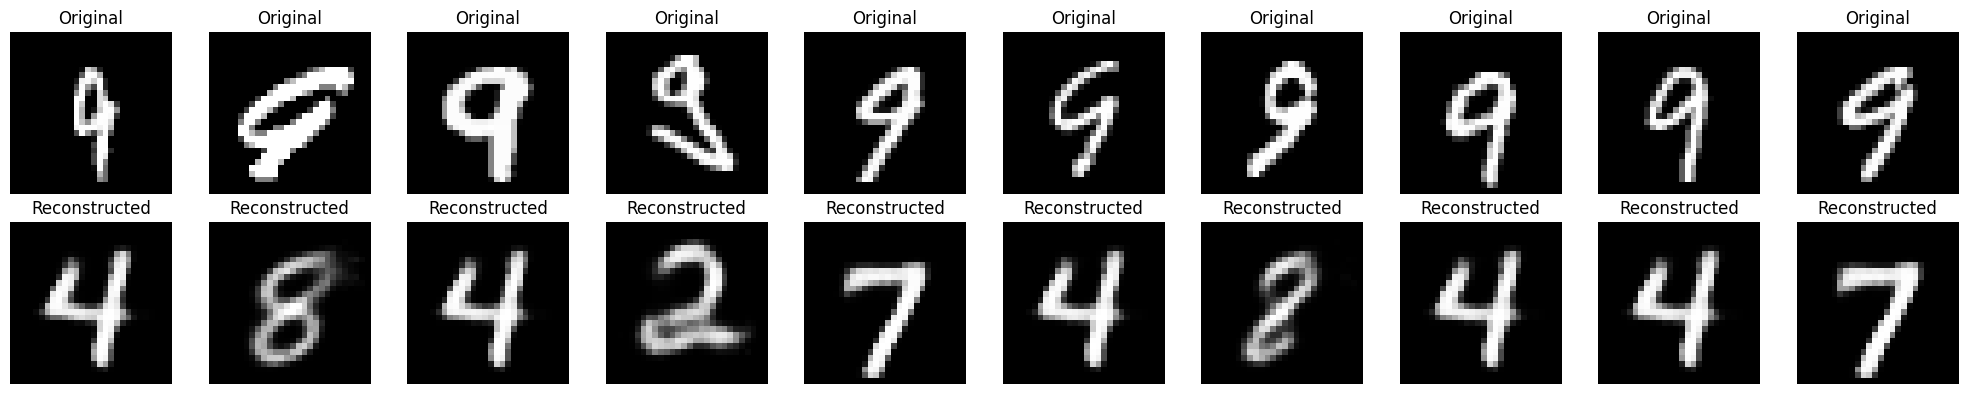

In [20]:
plot_ae_reconstructions(ae, train_dataset, indices=indices)

In [39]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

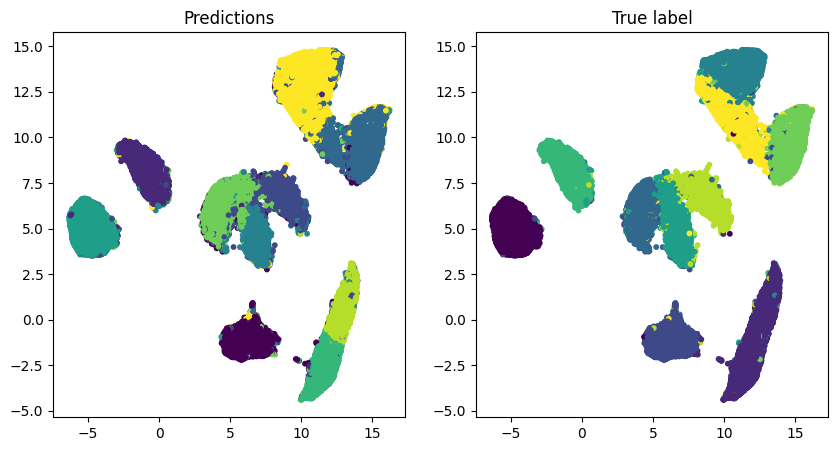

In [46]:
'''----- Umap form the input space -----'''
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(embedding[:, 0], embedding[:, 1], c=pred_labels, s=10)

ax[1].set_title('True label')
ax[1].scatter(embedding[:, 0], embedding[:, 1], c=labels, s=10)

plt.show()

In [40]:
latent_embedding = reducer.fit_transform(full_z_np)

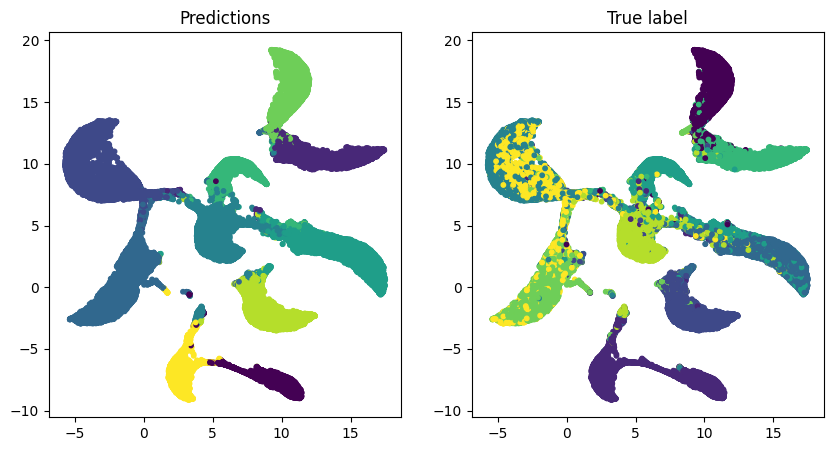

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(latent_embedding[:, 0], latent_embedding[:, 1], c=pred_labels, s=10)

ax[1].set_title('True label')
ax[1].scatter(latent_embedding[:, 0], latent_embedding[:, 1], c=labels, s=10)

plt.show()

In [70]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(data)

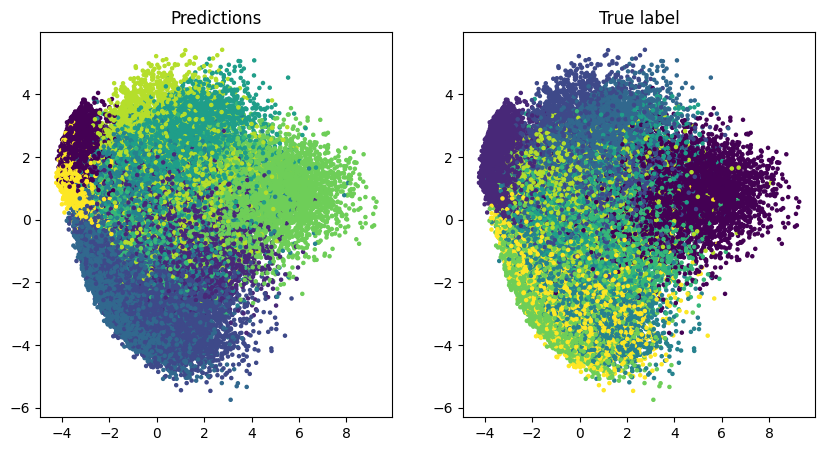

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1], c=pred_labels, s=5)

ax[1].set_title('True label')
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, s=5)

plt.show()

In [72]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(full_z_np)

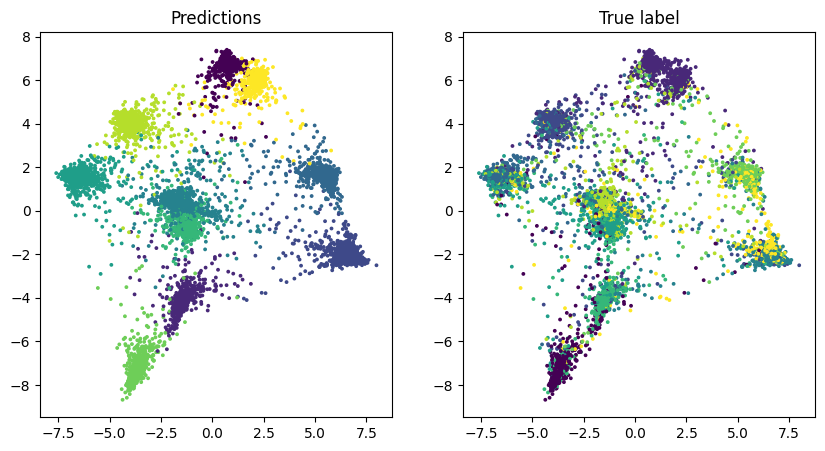

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Predictions')
ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1], c=pred_labels, s=3)

ax[1].set_title('True label')
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, s=3)

plt.show()